In [148]:
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split
import scipy
from collections import namedtuple
import numpy as np
import cupy as cp
import math

%run kernel.ipynb

4.89 μs ± 90.9 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
4.98 μs ± 26.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [149]:
config = Config()

In [150]:
%%time
IMAGES = []
IMAGE_FNAMES = {}

for image_fname in tqdm(os.listdir(config.dataset_path)):
    image_fname = os.path.join(config.dataset_path, image_fname)

    if not image_fname.endswith('.png'):
        continue

    # Following fuss with "with" is required to prevent "Too many open files" problem
    with Image.open(image_fname) as image:
        image.load()
        assert image.width == image.height
        assert image.mode == 'L'
        image_index = len(IMAGES)
        IMAGES.append(np.array(image).ravel())
        IMAGE_FNAMES[image_index] = image_fname
        
    assert image.fp is None

assert len(IMAGES) == len(IMAGE_FNAMES)
IMAGES = np.array(IMAGES)
print(f'Loaded {len(IMAGES)} images')

  0%|          | 0/9146 [00:00<?, ?it/s]

Loaded 9145 images
CPU times: user 413 ms, sys: 43 ms, total: 456 ms
Wall time: 454 ms


In [151]:
BASE_KERNEL_SIZE = 32
BAR_WIDTH = 4  # relative to BASE_KERNEL_SIZE. I.e. for 32 BAR_WIDTH would be 4/32, for 16 - 4/16, etc.
MAX_STRECH_FACTOR = 4
OFFSET_X_LEVELS = 17
OFFSET_Y_LEVELS = 17
STRETCH_X_LEVELS = 1
STRETCH_Y_LEVELS = 1
ROTATION_LEVELS = 24

assert MAX_BAR_WIDTH > BAR_WIDTH
assert STRETCH_X_LEVELS > 0 
assert STRETCH_Y_LEVELS > 0 
assert ROTATION_LEVELS > 0
assert OFFSET_X_LEVELS > 0 and OFFSET_X_LEVELS % 2
assert OFFSET_Y_LEVELS > 0 and OFFSET_Y_LEVELS % 2

In [152]:
offset_x_transfs = []
offset_y_transfs = []
stretch_x_transfs = []
stretch_y_transfs = []
rotation_transfs = []
identity_transf = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

# cover possible offsets from edge of an object to nearest edge of bounds
offset_x_transfs.append(identity_transf)

for i in range(OFFSET_X_LEVELS // 2):
    l = 0.5 / ((OFFSET_X_LEVELS - 1) // 2) * (i + 1)
    r = -l
    transf = [
        [1, 0, l],
        [0, 1, 0],
        [0, 0, 1]
    ]
    offset_x_transfs.append(np.array(transf))
    transf = [
        [1, 0, r],
        [0, 1, 0],
        [0, 0, 1]
    ]
    offset_x_transfs.append(np.array(transf))

# cover possible offsets from edge of an object to nearest edge of bounds
offset_y_transfs.append(identity_transf)

for i in range(OFFSET_Y_LEVELS // 2):
    u = 1 / ((OFFSET_Y_LEVELS - 1) // 2) * (i + 1)
    d = -u
    transf = [
        [1, 0, 0],
        [0, 1, u],
        [0, 0, 1]
    ]
    offset_y_transfs.append(np.array(transf))
    transf = [
        [1, 0, 0],
        [0, 1, d],
        [0, 0, 1]
    ]
    offset_y_transfs.append(np.array(transf))

# cover possible STRETCHES from 1x to MAX_STRETCH_FACTOR
for i in range(STRETCH_X_LEVELS):
    f = i * ((MAX_STRETCH_FACTOR - 1) / (STRETCH_X_LEVELS - 1)) + 1 if STRETCH_X_LEVELS > 1 else 1
    transf = [
        [f, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]
    stretch_x_transfs.append(np.array(transf))

# cover possible STRETCHES from 1x to MAX_STRETCH_FACTOR
for i in range(STRETCH_Y_LEVELS):
    f = i * ((MAX_STRETCH_FACTOR - 1) / (STRETCH_Y_LEVELS - 1)) + 1 if STRETCH_Y_LEVELS > 1 else 1
    transf = [
        [1, 0, 0],
        [0, f, 0],
        [0, 0, 1]
    ]
    stretch_y_transfs.append(np.array(transf))

# cover possible rotations counter clock wise (0 - is no rotation)
for i in range(ROTATION_LEVELS):
    theta = (2 * math.pi / ROTATION_LEVELS) * i
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)
    transf = [
        [cos_theta, sin_theta, 0],
        [-sin_theta, cos_theta, 0],
        [0, 0, 1]
    ]
    rotation_transfs.append(np.array(transf))

In [153]:
TRANSFS = []
break_on_transf = -1
i = 0

for a in stretch_x_transfs:
    for b in stretch_y_transfs:
        for c in rotation_transfs:
            for d in offset_x_transfs:
                for e in offset_y_transfs:
                    if break_on_transf > 0 and i == break_on_transf:
                         assert False
                    # https://learn.microsoft.com/en-us/dotnet/desktop/winforms/advanced/why-transformation-order-is-significant?view=netframeworkdesktop-4.8
                    # We need first scale, then rotate (around origin), then translate
                    transf = e @ d @ c @ b @ a
                    TRANSFS.append(transf)
                    i += 1

print(f'{len(TRANSFS)} transformations')

6936 transformations


In [154]:
def draw_kernel_bar(p1, p2, p3, p4, size=32):
    image = Image.new('L', (size, size), 0)
    draw = ImageDraw.Draw(image)
    draw.polygon([tuple(p1), tuple(p2), tuple(p3), tuple(p4)], fill=255, outline=255, width=1)
    return image

In [155]:
def draw_kernel_arc(p1, p2, start_angle=0, end_angle=360/4, size=32):
    image = Image.new('L', (size, size), 0)
    draw = ImageDraw.Draw(image)
    draw.arc([tuple(p1), tuple(p2)], start=start_angle, end=end_angle, fill=255, width=4)
    return image

In [156]:
def get_kernel_size(kernel):
    if len(kernel.shape) == 1: # Raveled array
        size = int(math.sqrt(kernel.shape[0]))
        assert size * size == kernel.shape[0]
        return size
        
    assert len(kernel.shape) == 2
    assert kernel.shape[0] == kernel.shape[1]
    assert kernel.dtype == np.uint8
    return kernel.shape[0]

In [157]:
def get_kernel_shape(kernel):
    sz = get_kernel_size(kernel)
    return (sz, sz)

In [158]:
def kernel_as_matrix(kernel):
    if len(kernel.shape) == 1: # Raveled array
        size = int(math.sqrt(kernel.shape[0]))
        assert size * size == kernel.shape[0]
        return kernel.reshape(size, size).astype(np.uint8)
        
    assert len(kernel.shape) == 2
    assert kernel.shape[0] == kernel.shape[1]
    assert kernel.dtype == np.uint8
    return kernel

In [159]:
def kernel_as_image(kernel):
    data = (kernel * 255).astype(np.uint8)
    return Image.frombytes('L', size=get_kernel_shape(kernel), data=data)

In [160]:
def display_kernel_raw(kernel):
    kernel = kernel_as_matrix(kernel)
    
    for r in kernel:
        s = ''
        for c in r:
            s += ' ' + str(c)

        print(s)            

In [161]:
lw = 1 / BASE_KERNEL_SIZE # line width 
hlw = lw / 2 # half line width
hbw = BAR_WIDTH * lw / 2 # half bar width
prototype_points_bar = np.array([
    [-hbw      , +0.25      , 1],
    [-hbw      , -0.25 + hlw, 1],
    [+hbw - hlw, -0.25 + hlw, 1],
    [+hbw - hlw, +0.25      , 1],
]).T
szsz = 32
center_pt = szsz / 2
#transf = e @ d @ c @ b @ a
#transf = offset_y_transfs[1]  @ rotation_transfs[3] @ stretch_x_transfs[4]
#transf = stretch_x_transfs[4]
# transf = offset_x_transfs[1]
# transf = stretch_x_transfs[6]
#transf = stretch_x_transfs[3]
# transf = stretch_y_transfs[5]
# transf = offset_y_transfs[5] @ stretch_y_transfs[5]
transf = identity_transf
points = (transf @ prototype_points_bar).T
# points_x = np.round(points[:,0] * szsz + center_pt).astype(np.int32)
# points_y = np.round(points[:,1] * -szsz + center_pt).astype(np.int32)
points_x = (points[:,0] * szsz + center_pt).astype(np.int32)
points_y = (points[:,1] * -szsz + center_pt).astype(np.int32)
kernel_image = draw_kernel_bar(
    (points_x[0], points_y[0]),
    (points_x[1], points_y[1]),
    (points_x[2], points_y[2]),
    (points_x[3], points_y[3]),
    size=szsz)
kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
#kernel_as_image(kernel).resize((320, 320))
display_kernel_raw(kernel)

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [162]:
l = '0 0 0 0 0 0 0 0 0 0 0 0 0 0'
r = '0 0 0 0 0 0 0 0 0 0 0 0 0 0'
(np.asmatrix(l) == 0).sum(), (np.asmatrix(r) == 0).sum(), 

(np.int64(14), np.int64(14))

In [163]:
prototype_points_arc = [
    [0 - 0.25,  0 + 0.25],
    [0 + 0.25,  0 - 0.25],
    [1,        1,       ]
]
szsz = 32
center_pt = szsz / 2
#transf = e @ d @ c @ b @ a
#transf = offset_y_transfs[1]  @ rotation_transfs[3] @ stretch_x_transfs[4]
#transf = stretch_x_transfs[4]
#transf = offset_x_transfs[1]
# transf = stretch_x_transfs[6]
#transf = stretch_x_transfs[3]
# transf = stretch_y_transfs[5]
# transf = offset_y_transfs[5] @ stretch_y_transfs[5]
transf = identity_transf
points = (transf @ prototype_points_arc).T
# points_x = np.round(points[:,0] * szsz + center_pt).astype(np.int32)
# points_y = np.round(points[:,1] * -szsz + center_pt).astype(np.int32)
points_x = (points[:,0] * szsz + center_pt).astype(np.int32)
points_y = (points[:,1] * -szsz + center_pt).astype(np.int32)
kernel_image = draw_kernel_arc(
    (points_x[0], points_y[0]),
    (points_x[1], points_y[1]),
    size=szsz)
kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
#kernel_as_image(kernel).resize((320, 320))
display_kernel_raw(kernel)

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [179]:
%%time
config.reload()
KERNELS = []
KERNEL_PARAMS = []
KERNELS_AS_OBJ = []

# prototype is a simple vertical bar of half size of kernel
lw = 1 / BASE_KERNEL_SIZE # line width 
hlw = lw / 2 # half line width
hbw = BAR_WIDTH * lw / 2 # half bar width
prototype_points_bar = np.array([
    [-hbw      , +0.25      , 1],
    [-hbw      , -0.25 + hlw, 1],
    [+hbw - hlw, -0.25 + hlw, 1],
    [+hbw - hlw, +0.25      , 1],
]).T
noncomplex_kernels_count = 0
center_pt = config.kernel_size / 2
transfs = TRANSFS
transfs = []

for transf in tqdm(transfs, desc='bar'):
    points = (transf @ prototype_points_bar).T
    points_x = (points[:,0] * config.kernel_size + center_pt).astype(np.int32)
    points_y = (points[:,1] * -config.kernel_size + center_pt).astype(np.int32)
    kernel_image = draw_kernel_bar(
        (points_x[0], points_y[0]),
        (points_x[1], points_y[1]),
        (points_x[2], points_y[2]),
        (points_x[3], points_y[3]),
        size=config.kernel_size)
    kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
    ones_count = (kernel == 1).sum()
    complexity = ones_count / len(kernel)

    if complexity <= config.kernel_min_complexity: 
        noncomplex_kernels_count += 1
        continue
    
    denominator = 255 * ones_count
    kernel = kernel.astype(np.float32)
    KERNELS.append(kernel)
    KERNEL_PARAMS.append([ones_count, denominator])

    kernel_as_obj = Kernel.from_m_data_nog((np.array(kernel_image) / 255).astype(np.uint8))
    assert kernel_as_obj.m_ones[0] == ones_count, (kernel_as_obj.m_ones[0], ones_count)
    KERNELS_AS_OBJ.append(kernel_as_obj)

arcs_per_360 = 8

for xcenter in tqdm(range(0, config.kernel_size, 2), 'arc'):
    for ycenter in range(0, config.kernel_size, 2):
        for angle in range(0, 360, 360//arcs_per_360):
            kernel_image = draw_kernel_arc(
                (xcenter - center_pt, ycenter - center_pt),
                (xcenter + center_pt, ycenter + center_pt),
                start_angle=angle,
                end_angle=angle + 360/arcs_per_360,
                size=config.kernel_size)
            kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
            ones_count = (kernel == 1).sum()
            complexity = ones_count / len(kernel)
        
            if complexity <= config.kernel_min_complexity: 
                noncomplex_kernels_count += 1
                continue
            
            denominator = 255 * ones_count
            kernel = kernel.astype(np.float32)
            KERNELS.append(kernel)
            KERNEL_PARAMS.append([ones_count, denominator])
        
            kernel_as_obj = Kernel.from_m_data_nog((np.array(kernel_image) / 255).astype(np.uint8))
            assert kernel_as_obj.m_ones[0] == ones_count, (kernel_as_obj.m_ones[0], ones_count)
            KERNELS_AS_OBJ.append(kernel_as_obj)

KERNELS = np.array(KERNELS)
KERNEL_PARAMS = np.array(KERNEL_PARAMS)
KERNELS_AS_OBJ = np.array(KERNELS_AS_OBJ)
assert len(KERNELS) == len(KERNEL_PARAMS)
assert len(KERNELS) == len(KERNELS_AS_OBJ)

print(f'{len(KERNELS)} kernels generated, {noncomplex_kernels_count} noncomplex omitted')

bar: 0it [00:00, ?it/s]

arc:   0%|          | 0/16 [00:00<?, ?it/s]

1170 kernels generated, 878 noncomplex omitted
CPU times: user 756 ms, sys: 3.99 ms, total: 760 ms
Wall time: 758 ms


In [180]:
%%time
# Deduplication
kernels_cross = KERNELS @ KERNELS.T
kernels_cross_norm = kernels_cross / KERNEL_PARAMS[:,0]
kernels_cross_norm_sum = kernels_cross_norm + kernels_cross_norm.T # 100% dups will give 1+1=2, 99% dups will give 0.99+0.99=1.98

CPU times: user 604 ms, sys: 3.61 ms, total: 607 ms
Wall time: 57.1 ms


In [181]:
# Verify cross score calculation
for _ in range(100):
    i = np.random.randint(kernels_cross.shape[0])
    j = np.random.randint(kernels_cross.shape[1])
    ones_j = KERNEL_PARAMS[j,0]
    #print(f'{i}\t{j}\t{kernels_cross[i,j]}\t{kernels_cross_norm[i,j]:.2f}\t{ones_j}')
    cross_norm = kernels_cross[i,j] / ones_j if ones_j > 0 else 0
    assert np.isclose(cross_norm, kernels_cross_norm[i,j]), (cross_norm, kernels_cross_norm[i,j])

In [182]:
%%time
KERNEL_DUPS_THRESHOLD=0.99
kernel_dups = []
kernels_for_remove = set()

for i, i_row in enumerate(kernels_cross_norm_sum):
    for j, s in enumerate(i_row):
        if j >= i: # either diagonal or upper right part of matrix encountered
            break

        if s >= (KERNEL_DUPS_THRESHOLD + KERNEL_DUPS_THRESHOLD): # treat 99% two-side intersection as redundant
            kernel_dups.append((i, j))
            kernels_for_remove.add(j)

total_kernel_for_remove = len(kernels_for_remove)
total_kernels = len(KERNELS)
print(f'Found {total_kernel_for_remove} of {total_kernels} ({(total_kernel_for_remove / total_kernels) * 100:.2f}%) duplicate kernels for {KERNEL_DUPS_THRESHOLD} threshold') 

Found 0 of 1170 (0.00%) duplicate kernels for 0.99 threshold
CPU times: user 75.6 ms, sys: 2.93 ms, total: 78.5 ms
Wall time: 77.5 ms


In [183]:
# Verify dups calculation against POJO Kernels
kernel_dups_indicies = np.random.randint(len(kernel_dups), size=100) if kernel_dups else []

for i in kernel_dups_indicies:
    dup_entry = kernel_dups[i]
    kernel1 = KERNELS_AS_OBJ[dup_entry[0]]
    kernel2 = KERNELS_AS_OBJ[dup_entry[1]]
    is_match1to2, match_score1to2 = kernel1.match(kernel2.m * 255, 0.01)
    is_match2to1, match_score2to1 = kernel2.match(kernel1.m * 255, 0.01)
    assert is_match1to2 == True
    assert is_match2to1 == True
    assert (match_score1to2 + match_score2to1) >= (KERNEL_DUPS_THRESHOLD + KERNEL_DUPS_THRESHOLD), (dup_entry, match_score1to2, match_score2to1)

In [184]:
KERNELS = np.delete(KERNELS, list(kernels_for_remove), axis=0)
KERNEL_PARAMS= np.delete(KERNEL_PARAMS, list(kernels_for_remove), axis=0)
KERNELS_AS_OBJ= np.delete(KERNELS_AS_OBJ, list(kernels_for_remove), axis=0)
print(f'{len(KERNELS)} unique kernels retained, {len(kernels_for_remove)} dropped')

1170 unique kernels retained, 0 dropped



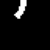
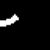
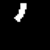
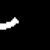
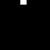
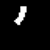
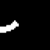
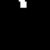
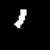
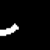
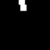
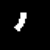
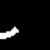
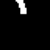
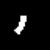
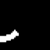
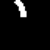
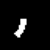
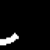
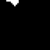
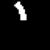
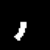
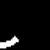
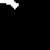
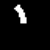
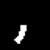
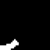
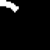
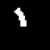
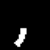
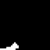
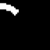
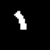
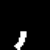
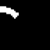
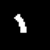
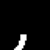
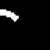
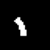
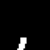
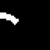
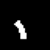
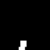
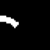
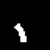
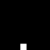
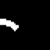
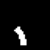
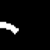
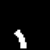
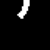
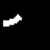
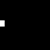
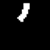
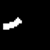
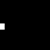
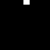
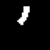
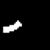
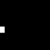
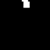
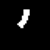
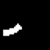
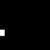
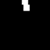
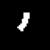
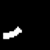
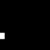
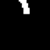
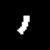
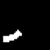
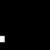
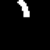
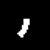
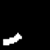
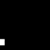
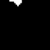
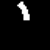
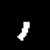
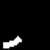
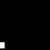
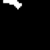
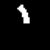
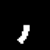
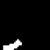
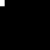
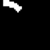
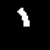
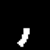
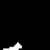
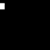
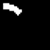
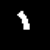
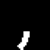
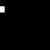
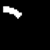
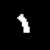
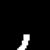
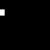
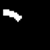
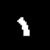
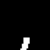
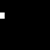
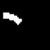
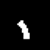
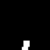
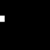
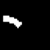
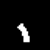
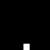
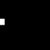
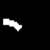
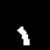
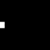
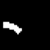
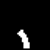
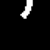
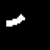
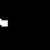
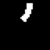
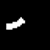
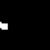
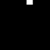
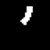
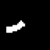
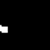
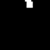
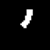
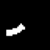
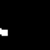
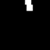
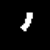
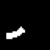
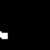
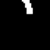
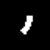
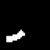
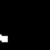
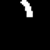
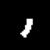
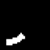
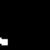
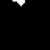
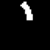
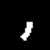
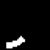
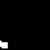
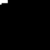
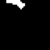
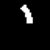
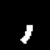
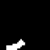
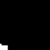
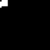
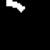
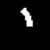
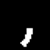
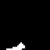
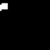
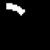
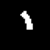
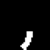
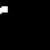
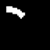
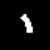
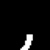
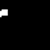
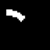
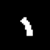
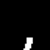
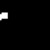
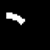
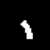
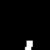
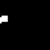
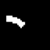
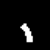
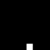
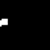
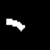
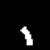
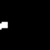
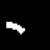
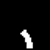
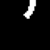
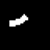
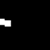
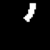
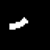
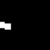
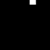
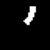
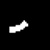
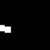
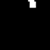
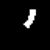
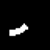
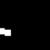
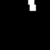
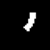
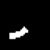
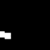
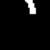
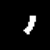
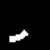
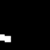
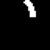
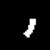
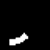
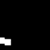
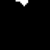
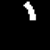
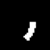
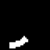
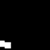
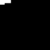
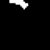
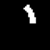
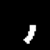
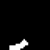
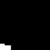
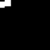
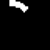
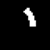
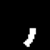
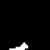
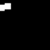
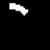
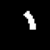
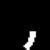
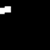
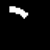
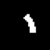
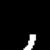
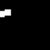
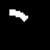
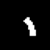
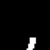
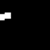
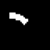
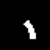
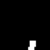
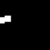
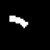
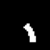
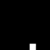
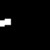
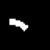
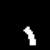
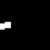
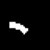
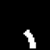
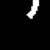
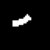
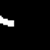
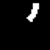

In [185]:
max_to_show = 256

if max_to_show > 0:
    kernel_images = np.copy(KERNELS[:max_to_show])
    kernel_image_denoms = KERNEL_PARAMS[:max_to_show,1]
else:
    kernel_images = np.copy(KERNELS)
    kernel_image_denoms = KERNEL_PARAMS[:,1]

# Turn to column vector
assert kernel_image_denoms.shape == (max_to_show,)
kernel_image_denoms = kernel_image_denoms.reshape(1,-1).T
assert kernel_image_denoms.shape == (max_to_show, 1)
kernel_images *= 255 # turn to 0..255

_images = []
_captions = dict()

for i in range(kernel_images.shape[0]):
    _image = Image.frombytes('L', size=get_kernel_shape(kernel_images[i]), data=kernel_images[i].astype(np.uint8))
    _image = _image.resize((50, 50))
    _images.append(_image)
    _captions[id(_image)] = i
    
display_images_grid(_images, 16, captions=_captions)

In [186]:
%%time

kernel_denoms = KERNEL_PARAMS[:,1]
kernel_denoms = kernel_denoms.reshape(1,-1).T # turn to column vector (many rows, single column)
KERNELS_SCALED = KERNELS / kernel_denoms 
MATCH_MATRIX_COVERAGE = IMAGES @ KERNELS.T # match matrix which favors kernels which cover more points of an image
MATCH_MATRIX_PRECISION = IMAGES @ KERNELS_SCALED.T # match matrix which favors kernels which cover points of an image with less error (excess)

CPU times: user 2.98 s, sys: 620 ms, total: 3.6 s
Wall time: 338 ms


In [187]:
# verify correctness vs Kernel POJO
image_random_indices = np.random.randint(len(IMAGES), size=(100,))
kernel_random_indices = np.random.randint(len(KERNELS), size=(100,))

for i in image_random_indices:
    for j in kernel_random_indices:
        match_score1 = MATCH_MATRIX_PRECISION[i,j]
        image = IMAGES[i].reshape(config.kernel_size, config.kernel_size)
        kernel = KERNELS_AS_OBJ[j]
        assert np.array_equal(kernel.m, KERNELS[j].reshape(config.kernel_size, config.kernel_size))
        match_score2 = kernel.match(image, 0.01)[1]
        assert np.isclose(match_score1, match_score2), (i, j, match_score1, match_score2)


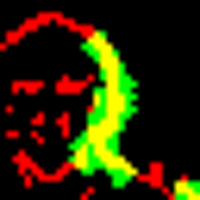
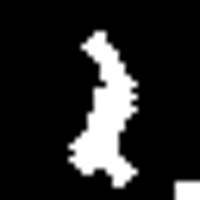
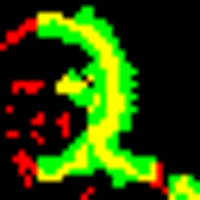
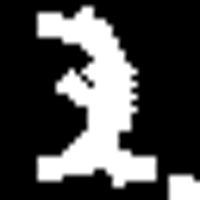
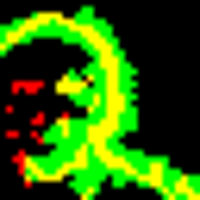
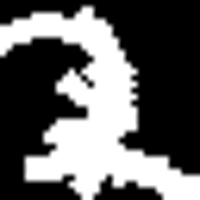
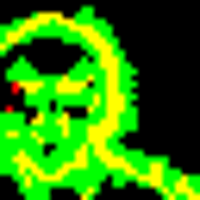
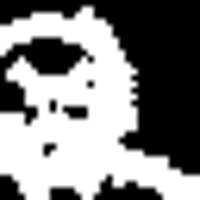
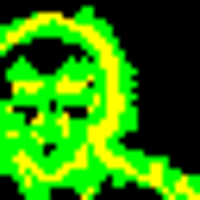
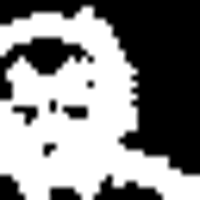

In [188]:
image_size_for_grid = (200, 200)

match_matrix_to_use = MATCH_MATRIX_COVERAGE
match_matrix_to_use = MATCH_MATRIX_PRECISION
image_index = np.random.randint(match_matrix_to_use.shape[0])
image_index = 4621
image_fname = IMAGE_FNAMES[image_index]
image = Image.open(image_fname)
image_on_pixels_array = np.ravel(np.array(image)) / 255
image_on_pixels_count = (image_on_pixels_array == 1).sum()

match_matrix_row = match_matrix_to_use[image_index]
kernel_indices_sorted_desc = np.argsort(-match_matrix_row)
#kernel_indices_matched_good_enough = np.argwhere(match_matrix_row > 0)
#kernel_indices_matched_good_enough_sorted_desc = kernel_indices_sorted_desc[np.isin(kernel_indices_sorted_desc, kernel_indices_matched_good_enough, assume_unique=True)]
kernel_indices_matched_good_enough_sorted_desc = kernel_indices_sorted_desc
images_in_grid = []
captions_in_grid = {}

for l in range(10, 50 + 10, 10):
    kernels_to_take_max = min(len(kernel_indices_matched_good_enough_sorted_desc), l)
    assert kernels_to_take_max > 0
    
    last_kernel_index = None
    kernels_in_composition = []
    kernels_composed = None
    kernels_composed_coverage = None
    kernels_composed_excess = None
    kernels_composed_error = None
    
    for kernel_index in kernel_indices_matched_good_enough_sorted_desc:
        kernel = KERNELS[kernel_index]

        # is it worth to add kernel to composition?
        
        # if not last_kernel_index is None:
        #     assert not kernels_composed is None
        #     tautology = (kernel @ kernels_composed.T) / KERNEL_PARAMS[kernel_index,0] # how current kernel relates with already composed
    
        #     if tautology > 0 and np.random.rand() < np.sqrt(tautology): # we hate tautology with a squared strenghts!
        #         continue

        if not last_kernel_index is None:
            assert not kernels_composed is None
            possible_composite_kernel = np.logical_or(kernels_composed, kernel)
            possible_coverage = (image_on_pixels_array @ possible_composite_kernel.T) / image_on_pixels_count

            if not (possible_coverage > kernels_composed_coverage):
                continue # this kernels adds nothing to composition => ignore
    
        kernels_in_composition.append(kernel)
        last_kernel_index = kernel_index
        kernels_composed = np.logical_or(kernels_composed, kernel) if not kernels_composed is None else kernel
        kernels_composed_on_pixels_count = (kernels_composed == 1).sum()
        assert kernels_composed_on_pixels_count > 0
        
        image_to_kernels_composed_match = image_on_pixels_array @ kernels_composed.T
        uncovered_image_on_pixels = image_on_pixels_count - image_to_kernels_composed_match
        assert uncovered_image_on_pixels >= 0
        kernels_composed_coverage = image_to_kernels_composed_match / image_on_pixels_count
        kernels_composed_redundant_on_pixels = kernels_composed_on_pixels_count - image_to_kernels_composed_match
        kernels_composed_excess = kernels_composed_redundant_on_pixels / kernels_composed_on_pixels_count
        kernels_composed_error = (kernels_composed_redundant_on_pixels + uncovered_image_on_pixels) / (kernels_composed_on_pixels_count + image_on_pixels_count)
    
        if len(kernels_in_composition) >= kernels_to_take_max:
            break
    
    kernel_image = Image.frombytes('L', size=get_kernel_shape(kernels_composed), data=(kernels_composed * 255).astype(np.uint8))
    kernel_image_for_display = kernel_image.resize(image_size_for_grid)
    
    image_plus_kernel = Image.merge('RGB', (image, kernel_image, image.point(lambda _: 0))).resize(image_size_for_grid)
    
    captions_in_grid[id(image_plus_kernel)] = f'''{image_index} ({image_fname})'''
    captions_in_grid[id(kernel_image_for_display)] = f'''
        {kernels_to_take_max}, 
        cov={kernels_composed_coverage*100:.0f}%, 
        excs={kernels_composed_excess*100:.0f}%, 
        err={kernels_composed_error*100:.0f}%'''
    images_in_grid.append(image_plus_kernel)
    images_in_grid.append(kernel_image_for_display)

display_images_grid(images_in_grid, col_count=2, captions=captions_in_grid)

In [174]:
KernelsCompositions = namedtuple('KernelsCompositions', 'kernels coverages excesses errors inspections')

def compute_kernels_compositions(match_matrix, kernels_max_count):
    images_on_pixels_array = IMAGES / 255
    images_on_pixels_count = images_on_pixels_array @ np.ones(IMAGES.shape[1]).T
    assert match_matrix.shape[0] == IMAGES.shape[0]
    assert match_matrix.shape[0] == images_on_pixels_array.shape[0]
    result = KernelsCompositions(
        kernels=np.empty((IMAGES.shape[0], KERNELS.shape[1])), # image index, kernels composition
        coverages=np.empty((IMAGES.shape[0])),
        excesses=np.empty((IMAGES.shape[0])),
        errors=np.empty((IMAGES.shape[0])),
        inspections=np.empty((IMAGES.shape[0])), # how many kernels were analyzed to come up with composition
    )
    match_matrix_kernel_indices_sorted_desc = np.argsort(-match_matrix, axis=-1)
    dataset_it = enumerate(zip(images_on_pixels_array, images_on_pixels_count, match_matrix_kernel_indices_sorted_desc))
        
    for image_index, (image_on_pixels_array, image_on_pixels_count, kernel_indices_sorted_desc) in tqdm(dataset_it, desc=f'Kernels max count={kernels_max_count}', total=IMAGES.shape[0]):
        if image_on_pixels_count == 0:
            result.kernels[image_index] = np.zeros(KERNELS.shape[1], dtype=np.uint8)
            result.coverages[image_index] = 0
            result.excesses[image_index] = 0
            result.errors[image_index] = 1
            result.inspections[image_index] = 0
            continue

        kernels_composed_indices = []
        kernels_composed = None
        kernels_composed_coverage = None
        kernels_composed_excess = None
        kernels_composed_error = None
        kernels_inspected = 0
        
        for kernel_index in kernel_indices_sorted_desc:
            kernels_inspected += 1
            kernel = KERNELS[kernel_index]
            possible_kernels_composed = None
            image_to_kernels_composed_match = None
            
            # is it worth to add kernel to composition?
            if kernels_composed_indices:
                assert not kernels_composed is None
                possible_kernels_composed = np.logical_or(kernels_composed, kernel)
                image_to_kernels_composed_match = (image_on_pixels_array @ possible_kernels_composed.T)
                possible_coverage = image_to_kernels_composed_match / image_on_pixels_count
    
                if not (possible_coverage > kernels_composed_coverage):
                    continue # this kernels adds nothing to composition => ignore
        
            kernels_composed_indices.append(kernel_index)

            if not possible_kernels_composed is None:
                kernels_composed = possible_kernels_composed
            else:
                kernels_composed = np.logical_or(kernels_composed, kernel) if not kernels_composed is None else kernel
                
            kernels_composed_on_pixels_count = (kernels_composed == 1).sum()
            assert kernels_composed_on_pixels_count > 0

            if image_to_kernels_composed_match is None:
                image_to_kernels_composed_match = image_on_pixels_array @ kernels_composed.T
                
            uncovered_image_on_pixels = image_on_pixels_count - image_to_kernels_composed_match
            assert uncovered_image_on_pixels >= 0
            kernels_composed_coverage = image_to_kernels_composed_match / image_on_pixels_count
            kernels_composed_redundant_on_pixels = kernels_composed_on_pixels_count - image_to_kernels_composed_match
            kernels_composed_excess = kernels_composed_redundant_on_pixels / kernels_composed_on_pixels_count
            kernels_composed_error = (kernels_composed_redundant_on_pixels + uncovered_image_on_pixels) / (kernels_composed_on_pixels_count + image_on_pixels_count)

            if len(kernels_composed_indices) > kernels_max_count:
                break

        assert not kernels_composed is None
        result.kernels[image_index] = kernels_composed
        result.coverages[image_index] = kernels_composed_coverage
        result.excesses[image_index] = kernels_composed_excess
        result.errors[image_index] = kernels_composed_error
        result.inspections[image_index] = kernels_inspected

    return result

In [175]:
kernels_compositions_coverage_10 = compute_kernels_compositions(MATCH_MATRIX_COVERAGE, 10)
kernels_compositions_precision_10 = compute_kernels_compositions(MATCH_MATRIX_PRECISION, 10)
kernels_compositions_coverage_25 = compute_kernels_compositions(MATCH_MATRIX_COVERAGE, 25)
kernels_compositions_precision_25 = compute_kernels_compositions(MATCH_MATRIX_PRECISION, 25)
kernels_compositions_coverage_50 = compute_kernels_compositions(MATCH_MATRIX_COVERAGE, 50)
kernels_compositions_precision_50 = compute_kernels_compositions(MATCH_MATRIX_PRECISION, 50)

Kernels max count=10:   0%|          | 0/9145 [00:00<?, ?it/s]

Kernels max count=10:   0%|          | 0/9145 [00:00<?, ?it/s]

Kernels max count=25:   0%|          | 0/9145 [00:00<?, ?it/s]

Kernels max count=25:   0%|          | 0/9145 [00:00<?, ?it/s]

Kernels max count=50:   0%|          | 0/9145 [00:00<?, ?it/s]

Kernels max count=50:   0%|          | 0/9145 [00:00<?, ?it/s]

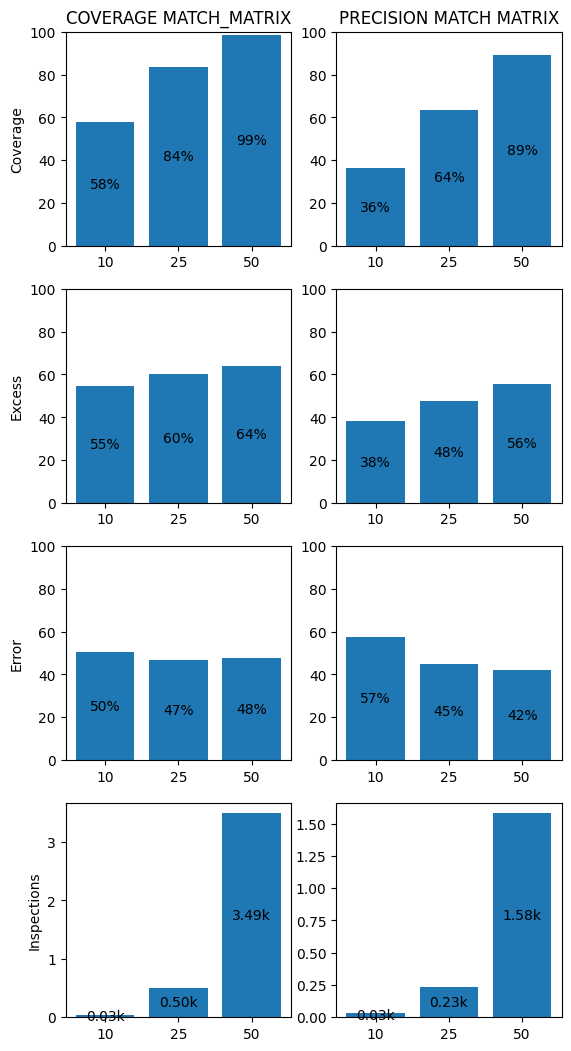

In [176]:
fig, ax = plt.subplots(4,2)
fig.set_figheight(fig.get_figwidth() * 2)

xvalues = list(map(str, [10, 25, 50]))

ax[0,0].set_title('COVERAGE MATCH_MATRIX')
ax[0,1].set_title('PRECISION MATCH MATRIX')

ax[0,0].set_ylabel('Coverage')
ax[0,0].set_ylim(0, 100)
ax[0,1].set_ylim(0, 100)

yvalues = np.mean(np.array([kernels_compositions_coverage_10.coverages, kernels_compositions_coverage_25.coverages, kernels_compositions_coverage_50.coverages]), axis=1) * 100
p = ax[0,0].bar(xvalues, yvalues)
ax[0,0].bar_label(p, labels=list(map(lambda y: f'{y:.0f}%', yvalues)), label_type='center')

yvalues = np.mean(np.array([kernels_compositions_precision_10.coverages, kernels_compositions_precision_25.coverages, kernels_compositions_precision_50.coverages]), axis=1) * 100
p = ax[0,1].bar(xvalues, yvalues)
ax[0,1].bar_label(p, labels=list(map(lambda y: f'{y:.0f}%', yvalues)), label_type='center')


ax[1,0].set_ylabel('Excess')
ax[1,0].set_ylim(0, 100)
ax[1,1].set_ylim(0, 100)

yvalues = np.mean(np.array([kernels_compositions_coverage_10.excesses, kernels_compositions_coverage_25.excesses, kernels_compositions_coverage_50.excesses]), axis=1) * 100
p = ax[1,0].bar(xvalues, yvalues)
ax[1,0].bar_label(p, labels=list(map(lambda y: f'{y:.0f}%', yvalues)), label_type='center')

yvalues = np.mean(np.array([kernels_compositions_precision_10.excesses, kernels_compositions_precision_25.excesses, kernels_compositions_precision_50.excesses]), axis=1) * 100
p = ax[1,1].bar(xvalues, yvalues)
ax[1,1].bar_label(p, labels=list(map(lambda y: f'{y:.0f}%', yvalues)), label_type='center')

ax[2,0].set_ylabel('Error')
ax[2,0].set_ylim(0, 100)
ax[2,1].set_ylim(0, 100)

yvalues = np.mean(np.array([kernels_compositions_coverage_10.errors, kernels_compositions_coverage_25.errors, kernels_compositions_coverage_50.errors]), axis=1) * 100
p = ax[2,0].bar(xvalues, yvalues)
ax[2,0].bar_label(p, labels=list(map(lambda y: f'{y:.0f}%', yvalues)), label_type='center')

yvalues = np.mean(np.array([kernels_compositions_precision_10.errors, kernels_compositions_precision_25.errors, kernels_compositions_precision_50.errors]), axis=1) * 100
p = ax[2,1].bar(xvalues, yvalues)
ax[2,1].bar_label(p, labels=list(map(lambda y: f'{y:.0f}%', yvalues)), label_type='center')

ax[3,0].set_ylabel('Inspections')

yvalues = np.mean(np.array([kernels_compositions_coverage_10.inspections, kernels_compositions_coverage_25.inspections, kernels_compositions_coverage_50.inspections]), axis=1) / 1000
p = ax[3,0].bar(xvalues, yvalues)
ax[3,0].bar_label(p, labels=list(map(lambda y: f'{y:.2f}k', yvalues)), label_type='center')

yvalues = np.mean(np.array([kernels_compositions_precision_10.inspections, kernels_compositions_precision_25.inspections, kernels_compositions_precision_50.inspections]), axis=1) / 1000
p = ax[3,1].bar(xvalues, yvalues)
ax[3,1].bar_label(p, labels=list(map(lambda y: f'{y:.2f}k', yvalues)), label_type='center')


plt.show()